In [2]:
import pandas as pd
import os
import sys

project_root = os.path.dirname(os.getcwd())
print(project_root)
df = pd.read_parquet(os.path.join(project_root, 'lead_lag_matrices.parquet'))
print(df)

/Users/evanheus/Desktop/AFP
                     timestamp method stock1 stock2     value
0    2024-11-29 09:35:00-05:00     C1   AAPL   AAPL  0.000000
1    2024-11-29 09:35:00-05:00     C1   AAPL   TSLA  0.072921
2    2024-11-29 09:35:00-05:00     C1   AAPL   AMZN -1.000000
3    2024-11-29 09:35:00-05:00     C1   AAPL    SPY -1.000000
4    2024-11-29 09:35:00-05:00     C1   TSLA   AAPL -0.072921
...                        ...    ...    ...    ...       ...
6171 2024-11-29 16:00:00-05:00     C1   AMZN    SPY -1.000000
6172 2024-11-29 16:00:00-05:00     C1    SPY   AAPL  0.608287
6173 2024-11-29 16:00:00-05:00     C1    SPY   TSLA  1.000000
6174 2024-11-29 16:00:00-05:00     C1    SPY   AMZN  1.000000
6175 2024-11-29 16:00:00-05:00     C1    SPY    SPY  0.000000

[6176 rows x 5 columns]


In [33]:
df[df['timestamp'] == '2024-11-29 09:35:00-05:00']

,timestamp,method,stock1,stock2,value
0,2024-11-29 09:35:00-05:00,C1,AAPL,AAPL,0.000000
1,2024-11-29 09:35:00-05:00,C1,AAPL,TSLA,0.072921
2,2024-11-29 09:35:00-05:00,C1,AAPL,AMZN,-1.000000
3,2024-11-29 09:35:00-05:00,C1,AAPL,SPY,-1.000000
4,2024-11-29 09:35:00-05:00,C1,TSLA,AAPL,-0.072921
5,2024-11-29 09:35:00-05:00,C1,TSLA,TSLA,0.000000
6,2024-11-29 09:35:00-05:00,C1,TSLA,AMZN,-0.101946
7,2024-11-29 09:35:00-05:00,C1,TSLA,SPY,-0.514901
8,2024-11-29 09:35:00-05:00,C1,AMZN,AAPL,1.000000
9,2024-11-29 09:35:00-05:00,C1,AMZN,TSLA,0.101946


In [31]:
import pandas as pd
import numpy as np
from typing import Dict, List

def create_leadlag_matrices(parquet_file: str) -> Dict[pd.Timestamp, pd.DataFrame]:
    """
    Create lead-lag matrices for each timestamp from the parquet file.
    
    Parameters:
    -----------
    parquet_file : str
        Path to the parquet file containing lead-lag relationships
        
    Returns:
    --------
    Dict[pd.Timestamp, pd.DataFrame]:
        Dictionary mapping timestamps to their corresponding lead-lag matrices
    """
    # Read parquet file
    df = pd.read_parquet(parquet_file)
    
    # Get unique stocks and timestamps in sorted order
    unique_stocks = sorted(df['stock1'].unique())
    unique_timestamps = sorted(df['timestamp'].unique())
    
    # Dictionary to store matrices
    matrices = {}
    
    # Create matrix for each timestamp
    for timestamp in unique_timestamps:
        time_data = df[df['timestamp'] == timestamp]
        matrix = np.zeros((len(unique_stocks), len(unique_stocks)))
        
        # Fill the matrix
        for _, row in time_data.iterrows():
            i = unique_stocks.index(row['stock1'])
            j = unique_stocks.index(row['stock2'])
            matrix[i, j] = row['value']
        
        # Convert to DataFrame with labels
        matrices[timestamp] = pd.DataFrame(
            matrix,
            index=unique_stocks,
            columns=unique_stocks
        )
    
    return matrices

def display_leadlag_matrix(matrix: pd.DataFrame, timestamp: pd.Timestamp) -> None:
    """
    Display a lead-lag matrix with interpretation.
    
    Parameters:
    -----------
    matrix : pd.DataFrame
        Lead-lag matrix with labeled axes
    timestamp : pd.Timestamp
        Timestamp of the matrix
    """
    print(f"\nLead-Lag Matrix for {timestamp}")
    print("\nRow (i) → Column (j) represents stock i leading stock j")
    print(matrix.round(4))
    
    # Find strongest relationship
    max_abs_val = np.abs(matrix.values).max()
    if max_abs_val > 0:
        max_idx = np.unravel_index(np.abs(matrix.values).argmax(), matrix.shape)
        leader = matrix.index[max_idx[0]]
        lagger = matrix.columns[max_idx[1]]
        value = matrix.values[max_idx]
        print(f"\nStrongest relationship: {leader} leading {lagger} with value {value:.4f}")

# Example usage
if __name__ == "__main__":
    parquet_file = os.path.join(project_root, 'lead_lag_matrices.parquet')
    
    # Create matrices for all timestamps
    matrices = create_leadlag_matrices(parquet_file)
    
    # Display information
    print(f"Number of timestamps: {len(matrices)}")
    print(f"Stock universe: {sorted(matrices[list(matrices.keys())[0]].index)}")
    
    # Display matrices for each timestamp
    for timestamp, matrix in matrices.items():
        display_leadlag_matrix(matrix, timestamp)

Number of timestamps: 386
Stock universe: ['AAPL', 'AMZN', 'SPY', 'TSLA']

Lead-Lag Matrix for 2024-11-29 09:35:00-05:00

Row (i) → Column (j) represents stock i leading stock j
        AAPL    AMZN     SPY    TSLA
AAPL  0.0000 -1.0000 -1.0000  0.0729
AMZN  1.0000  0.0000 -1.0000  0.1019
SPY   1.0000  1.0000  0.0000  0.5149
TSLA -0.0729 -0.1019 -0.5149  0.0000

Strongest relationship: AAPL leading AMZN with value -1.0000

Lead-Lag Matrix for 2024-11-29 09:36:00-05:00

Row (i) → Column (j) represents stock i leading stock j
        AAPL    AMZN     SPY    TSLA
AAPL  0.0000  0.1913 -1.0000  0.0869
AMZN -0.1913  0.0000 -0.3036  1.0000
SPY   1.0000  0.3036  0.0000  0.4435
TSLA -0.0869 -1.0000 -0.4435  0.0000

Strongest relationship: AAPL leading SPY with value -1.0000

Lead-Lag Matrix for 2024-11-29 09:37:00-05:00

Row (i) → Column (j) represents stock i leading stock j
        AAPL    AMZN     SPY    TSLA
AAPL  0.0000 -1.0000  0.2945  0.1600
AMZN  1.0000  0.0000 -0.2215  0.0063
SPY  -0.29

In [35]:
type(matrices)

dict

In [37]:
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple

def create_leadlag_matrices(parquet_file: str) -> Dict[pd.Timestamp, pd.DataFrame]:
    """Create basic lead-lag matrices dictionary from parquet file"""
    df = pd.read_parquet(parquet_file)
    unique_stocks = sorted(df['stock1'].unique())
    unique_timestamps = sorted(df['timestamp'].unique())
    matrices = {}
    
    for timestamp in unique_timestamps:
        time_data = df[df['timestamp'] == timestamp]
        matrix = np.zeros((len(unique_stocks), len(unique_stocks)))
        
        for _, row in time_data.iterrows():
            i = unique_stocks.index(row['stock1'])
            j = unique_stocks.index(row['stock2'])
            matrix[i, j] = row['value']
        
        matrices[pd.Timestamp(timestamp)] = pd.DataFrame(
            matrix,
            index=unique_stocks,
            columns=unique_stocks
        )
    
    return matrices

def create_rolling_windows(
    matrices: Dict[pd.Timestamp, pd.DataFrame],
    lookback: int,
    frequency: str = '1min'
) -> Tuple[np.ndarray, List[pd.Timestamp]]:
    """
    Create rolling windows of matrices.
    
    Parameters:
    -----------
    matrices : Dict[pd.Timestamp, pd.DataFrame]
        Dictionary of timestamp to lead-lag matrices
    lookback : int
        Number of historical matrices to include in each window
    frequency : str
        Frequency to sample windows (e.g., '1min', '5min')
        
    Returns:
    --------
    Tuple containing:
        - numpy.ndarray: 4D tensor of shape (num_windows, lookback, num_stocks, num_stocks)
        - List[pd.Timestamp]: List of timestamps corresponding to end of each window
    """
    timestamps = sorted(matrices.keys())
    num_stocks = matrices[timestamps[0]].shape[0]
    
    # Create frequency-based sampling points starting after we have enough history
    start_time = timestamps[lookback - 1]  # Need lookback-1 matrices before start
    end_time = timestamps[-1]
    sampling_points = pd.date_range(start=start_time, end=end_time, freq=frequency)
    
    # Filter sampling points to ensure we only use points where we have data
    valid_sampling_points = [t for t in sampling_points if t in timestamps]
    
    # Initialize tensor
    num_windows = len(valid_sampling_points)
    tensor = np.zeros((num_windows, lookback, num_stocks, num_stocks))
    window_timestamps = []
    
    # Fill tensor with rolling windows
    for i, end_time in enumerate(valid_sampling_points):
        # Get the index of current end_time in original timestamps
        end_idx = timestamps.index(end_time)
        
        # Get the previous lookback matrices
        for j in range(lookback):
            matrix_time = timestamps[end_idx - (lookback - 1) + j]
            tensor[i, j] = matrices[matrix_time].values
        
        window_timestamps.append(end_time)
    
    return tensor, window_timestamps

def display_tensor_info(
    tensor: np.ndarray,
    window_timestamps: List[pd.Timestamp],
    matrices: Dict[pd.Timestamp, pd.DataFrame]
) -> None:
    """Display information about the created tensor"""
    print(f"Tensor shape: {tensor.shape}")
    print(f"Interpretation:")
    print(f"- Number of windows: {tensor.shape[0]}")
    print(f"- Matrices per window (lookback): {tensor.shape[1]}")
    print(f"- Matrix dimensions: {tensor.shape[2]}x{tensor.shape[3]}")
    print(f"\nStock universe: {list(matrices[window_timestamps[0]].index)}")
    print(f"\nFirst window ends at: {window_timestamps[0]}")
    print(f"Last window ends at: {window_timestamps[-1]}")
    
    # Show example window
    print(f"\nExample - First window matrices:")
    for i in range(tensor.shape[1]):
        print(f"\nMatrix {i+1} of {tensor.shape[1]}:")
        df = pd.DataFrame(
            tensor[0, i],
            index=matrices[window_timestamps[0]].index,
            columns=matrices[window_timestamps[0]].columns
        )
        print(df.round(4))

# Example usage
if __name__ == "__main__":
    parquet_file = os.path.join(project_root, 'lead_lag_matrices.parquet')
    lookback = 5  # Use 5 historical matrices
    frequency = '1min'  # Sample every minute
    
    # First create base matrices
    matrices = create_leadlag_matrices(parquet_file)
    
    # Create rolling windows tensor
    tensor, window_timestamps = create_rolling_windows(matrices, lookback, frequency)
    
    # Display information
    display_tensor_info(tensor, window_timestamps, matrices)

Tensor shape: (382, 5, 4, 4)
Interpretation:
- Number of windows: 382
- Matrices per window (lookback): 5
- Matrix dimensions: 4x4

Stock universe: ['AAPL', 'AMZN', 'SPY', 'TSLA']

First window ends at: 2024-11-29 09:39:00-05:00
Last window ends at: 2024-11-29 16:00:00-05:00

Example - First window matrices:

Matrix 1 of 5:
        AAPL    AMZN     SPY    TSLA
AAPL  0.0000 -1.0000 -1.0000  0.0729
AMZN  1.0000  0.0000 -1.0000  0.1019
SPY   1.0000  1.0000  0.0000  0.5149
TSLA -0.0729 -0.1019 -0.5149  0.0000

Matrix 2 of 5:
        AAPL    AMZN     SPY    TSLA
AAPL  0.0000  0.1913 -1.0000  0.0869
AMZN -0.1913  0.0000 -0.3036  1.0000
SPY   1.0000  0.3036  0.0000  0.4435
TSLA -0.0869 -1.0000 -0.4435  0.0000

Matrix 3 of 5:
        AAPL    AMZN     SPY    TSLA
AAPL  0.0000 -1.0000  0.2945  0.1600
AMZN  1.0000  0.0000 -0.2215  0.0063
SPY  -0.2945  0.2215  0.0000  1.0000
TSLA -0.1600 -0.0063 -1.0000  0.0000

Matrix 4 of 5:
        AAPL    AMZN     SPY    TSLA
AAPL  0.0000 -1.0000  0.0848 -0.38

In [39]:
df[df['timestamp'] == '2024-11-29 09:36:00-05:00']

,timestamp,method,stock1,stock2,value
16,2024-11-29 09:36:00-05:00,C1,AAPL,AAPL,0.000000
17,2024-11-29 09:36:00-05:00,C1,AAPL,TSLA,0.086888
18,2024-11-29 09:36:00-05:00,C1,AAPL,AMZN,0.191296
19,2024-11-29 09:36:00-05:00,C1,AAPL,SPY,-1.000000
20,2024-11-29 09:36:00-05:00,C1,TSLA,AAPL,-0.086888
21,2024-11-29 09:36:00-05:00,C1,TSLA,TSLA,0.000000
22,2024-11-29 09:36:00-05:00,C1,TSLA,AMZN,-1.000000
23,2024-11-29 09:36:00-05:00,C1,TSLA,SPY,-0.443548
24,2024-11-29 09:36:00-05:00,C1,AMZN,AAPL,-0.191296
25,2024-11-29 09:36:00-05:00,C1,AMZN,TSLA,1.000000


<Axes: title={'center': 'TSLA Volume'}, ylabel='Volume'>

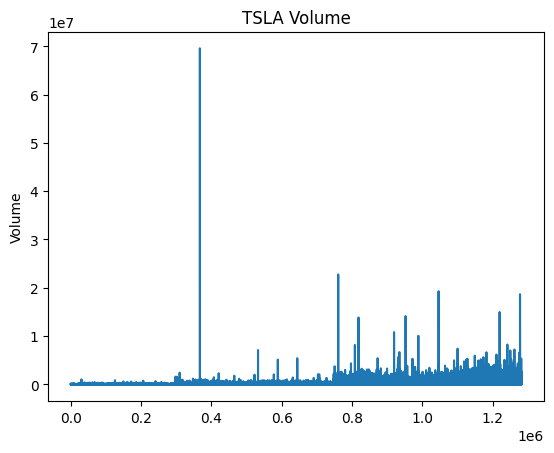

In [3]:
tsla = pd.read_parquet(os.path.join(project_root, 'data', 'ohlcv', 'TSLA_ohlcv.parquet'))
tsla['volume'].plot(title='TSLA Volume', ylabel='Volume')

In [6]:
tsla

,rtype,publisher_id,instrument_id,open,high,low,close,volume,symbol,timestamp
0,33,2,7804,326.42,326.50,325.16,325.16,936,TSLA,2019-01-02 09:02:00+00:00
1,33,2,7804,326.39,326.50,326.39,326.50,59,TSLA,2019-01-02 09:03:00+00:00
2,33,2,7804,325.70,325.70,325.70,325.70,557,TSLA,2019-01-02 09:04:00+00:00
3,33,2,7804,327.00,327.00,327.00,327.00,10,TSLA,2019-01-02 09:08:00+00:00
4,33,2,7804,327.50,327.50,327.50,327.50,25,TSLA,2019-01-02 09:09:00+00:00
...,...,...,...,...,...,...,...,...,...,...
1282041,33,2,16244,413.95,414.00,413.91,413.95,355,TSLA,2024-12-30 23:55:00+00:00
1282042,33,2,16244,413.90,413.90,413.80,413.87,399,TSLA,2024-12-30 23:56:00+00:00
1282043,33,2,16244,413.82,413.82,413.69,413.69,599,TSLA,2024-12-30 23:57:00+00:00
1282044,33,2,16244,413.66,413.70,413.29,413.50,2936,TSLA,2024-12-30 23:58:00+00:00


<Axes: title={'center': 'TSLA Volume'}, ylabel='Volume'>

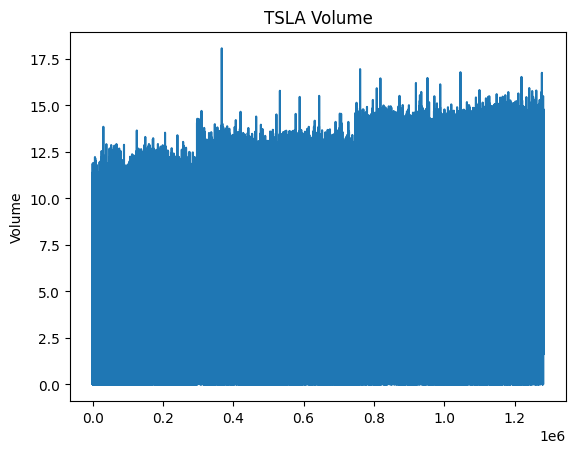

In [5]:
import numpy as np

np.log(tsla['volume']).plot(title='TSLA Volume', ylabel='Volume')

<Axes: title={'center': 'TSLA Volume'}, xlabel='time', ylabel='Volume'>

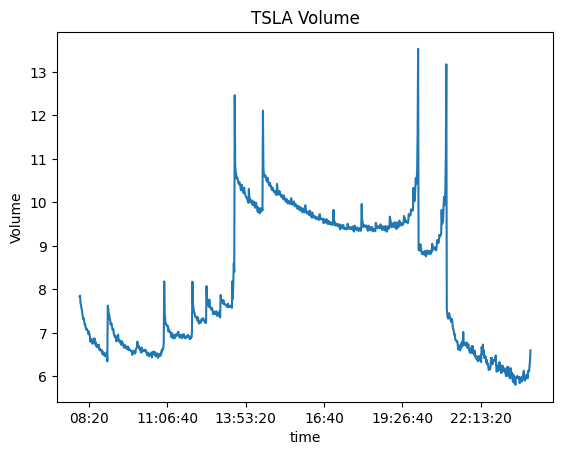

In [ ]:
tmp = tsla.set_index('timestamp')
tmp['volume'].groupby(tmp.index.time).mean()).plot(title='TSLA Volume', ylabel='log Volume')

In [13]:
tsla.set_index('timestamp').index.time

array([datetime.time(9, 2), datetime.time(9, 3), datetime.time(9, 4), ...,
       datetime.time(23, 57), datetime.time(23, 58),
       datetime.time(23, 59)], shape=(1282046,), dtype=object)

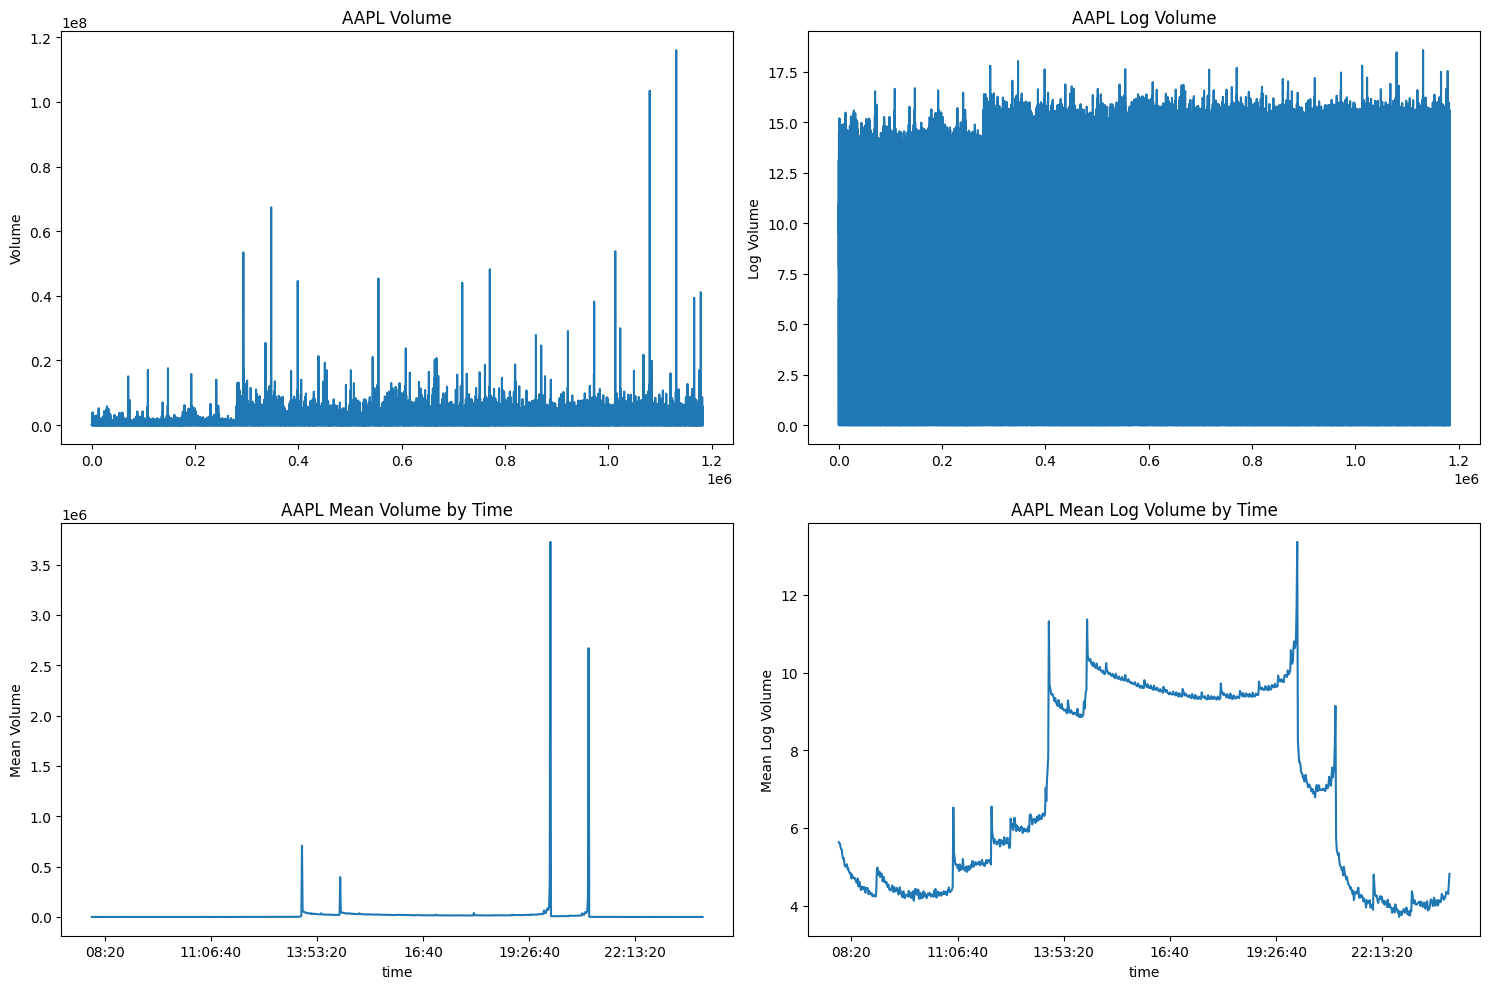

In [16]:
import matplotlib.pyplot as plt

# Import Apple stock data
aapl = pd.read_parquet(os.path.join(project_root, 'data', 'ohlcv', 'AAPL_ohlcv.parquet'))

# Create a matplotlib grid for the plots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot the volume of Apple stock
aapl['volume'].plot(ax=axs[0, 0], title='AAPL Volume', ylabel='Volume')

# Plot the log volume of Apple stock
np.log(aapl['volume']).plot(ax=axs[0, 1], title='AAPL Log Volume', ylabel='Log Volume')

# Plot the mean volume of Apple stock grouped by time
tmp_aapl = aapl.set_index('timestamp')
tmp_aapl['volume'].groupby(tmp_aapl.index.time).mean().plot(ax=axs[1, 0], title='AAPL Mean Volume by Time', ylabel='Mean Volume')

# Plot the mean log volume of Apple stock grouped by time
np.log(tmp_aapl['volume']).groupby(tmp_aapl.index.time).mean().plot(ax=axs[1, 1], title='AAPL Mean Log Volume by Time', ylabel='Mean Log Volume')

plt.tight_layout()
plt.show()